## New York Taxi fare Prediction

- Decision Tree, Random Forest and XGBoost Regression technique to predict the taxi fare
- Train data is huge so we will be taking only sample of data (100k records) for building the model
- Result will improve if increase the train size and do some Hyperparameter tuning with cross validation. Due to memory issue in Kaggle environment, chose to go with only 100k records.

## Steps Taken to build the model
- Load the data / Cleanup the data
- Feature Engineering
- Exploratory Data Anaysis
- Univariate and Bivariate Anaysis
- Distribution of data
- Decision Tree for Predict the taxi fare
- Random Forest for Predicting the taxi fare
- XGBoost for Predicting the taxi fare

## Result
- Descision Tree: 77.9 % accuracy
- Random Forest: 78.4 % accuracy
- XGBoost: 85.46% accuracy

## Final Result: XGBoost accuracy is 85.46% is much higher than Random Forest and Decision Tree which proves that XGBoost is the best in predicting the New York Taxi fares


In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [201]:
## Load 100k rows only
data = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows=100_000, parse_dates=['pickup_datetime'])


In [202]:
print(data.shape)
print(data.info())

(100000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB
None


In [203]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [204]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


## Fare Amount Distribution

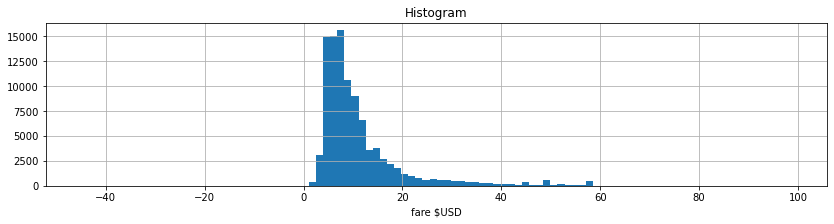

In [205]:
data[data.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

### Calculate the distance between two GPS location
- actual lat long are not useful for modeling
- we will calculate the distance between two points

In [206]:
from math import sin, cos, sqrt, atan2, radians

def calculateDistance(lt1, ln1, lt2, ln2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lt1)
    lon1 = radians(ln1)
    lat2 = radians(lt2)
    lon2 = radians(ln2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 1000
    
    return distance

## Feature Engineering
- pickup_datetime will not help much in feature selection
- We can extract weekday and pickup_time from the pickup_datetime which will be very good feature for prediction
- Weekday will tell which day has peak day in the month
- Pickup Time will tell which is a peak hour in a day

## Data Cleanup
- Remove the rows which have fare amount as negative which doesn't make sense
- Remove the rows which have distance as <=0
- Also we will remove all the rows which have nan values

In [207]:
def featureCleanup(dfOrig, train = True):
    if(train):
        df = dfOrig[dfOrig['fare_amount'] >= 0]
    else:
        df = dfOrig.copy()
        
    df['weekday'] = df['pickup_datetime'].dt.day_name()
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_time'] = df['pickup_datetime'].dt.hour + df['pickup_datetime'].dt.minute/60
    
    df['distance'] = df.apply(lambda x: 
                              calculateDistance(x['pickup_latitude'], 
                                                x['pickup_longitude'],
                                                x['dropoff_latitude'],
                                                x['dropoff_longitude']), 
                              axis=1)
    
    df.drop(columns = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pickup_datetime','key'], 
          inplace = True)
    
    if(train):
        df.dropna(
            axis=0,
            how='any',
            thresh=None,
            subset=None,
            inplace=True
        )

        df = df[df['distance'] > 0]
    
    return df

In [208]:
trainData = featureCleanup(data)

In [221]:
trainData.head()

,fare_amount,passenger_count,weekday,pickup_hour,pickup_time,distance
0,4.5,1,Monday,17,17.433333,1031.087515
1,16.9,1,Tuesday,16,16.866667,8452.786283
2,5.7,2,Thursday,0,0.583333,1389.961429
3,7.7,1,Saturday,4,4.500000,2800.148994
4,5.3,1,Tuesday,7,7.850000,1999.784368


In [241]:
def plotChart(df, x, y, title, num):
    plt.subplot(5, 2, num)
    sns.lineplot(data = df, x= x, y = y)
    plt.title(title)
    #plt.xticks(rotation = 90)
    plt.legend(loc='upper right')

# Exploratory Data Analysis

## Bivariate Analysis
- Generally taxi fares are expensive on Sundays 
- Generally people are travelling on Sundays or Wednesday (wednesday has max distance because of an outlier)
- Taxi fare is maximum during 2AM - 4AM. Midnight Charges ?
- Outlier causing issue with distance vs fare distribution

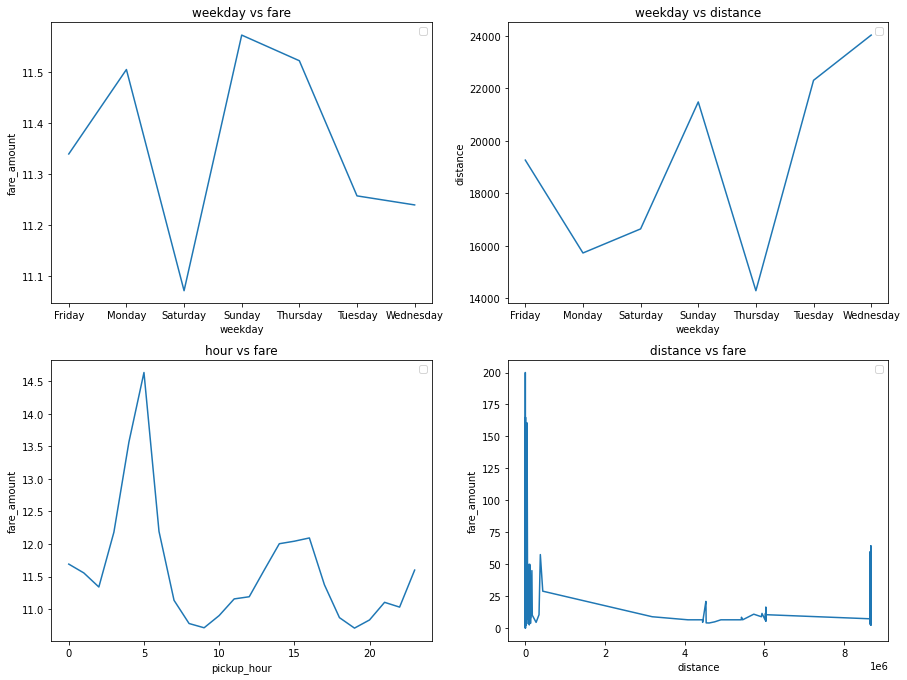

In [244]:
plt.figure(figsize  = (15,30))
plotChart(trainData.groupby(by="weekday").mean().reset_index(), 'weekday', 'fare_amount', 'weekday vs fare', 1)
plotChart(trainData.groupby(by="weekday").mean().reset_index(), 'weekday', 'distance', 'weekday vs distance', 2)
plotChart(trainData.groupby(by="pickup_hour").mean().reset_index(), 'pickup_hour', 'fare_amount', 'hour vs fare', 3)
plotChart(trainData.groupby(by="distance").mean().reset_index(), 'distance', 'fare_amount', 'distance vs fare', 4)

## Univariate Analysis
- Single passenger Taxi hire has maximum trend, hiring taxi from office to home ?
- Thurday, Friday and Saturday has maximum taxi hiring count
- Moderate hour is from 9:00 AM to 5:00 PM
- Peak hour is from 6:00PM to 9:00PM, leaving from office to home ?

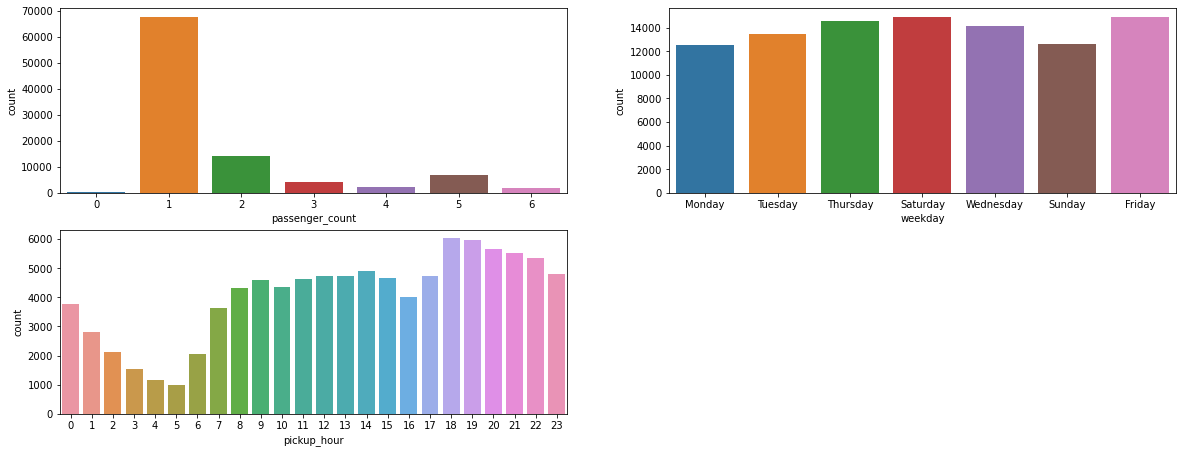

In [247]:
plt.figure(figsize  = (20,40))
for i in enumerate(trainData.columns.drop(['fare_amount', 'distance', 'pickup_time'])):
    plt.subplot(10, 2, i[0]+1)
    sns.countplot(trainData[i[1]])


## Outliers Detection
- There are outliers in the dataset but it will not impact on ML models based on decision tree.
- Outlier detection and treatment are not required here.

### Convert Weekday names with numeric numbers
- ML models always look for numbers not String values so converting weeknames to weeknumber.

In [169]:
trainData.drop(columns=['pickup_hour'], inplace=True)
trainData['weekday'] = trainData['weekday'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7})

In [170]:
y_train = trainData.pop('fare_amount')
X_train = trainData

In [171]:
X_train.head()

,passenger_count,weekday,pickup_time,distance
0,1,1,17.433333,1031.087515
1,1,2,16.866667,8452.786283
2,2,4,0.583333,1389.961429
3,1,6,4.500000,2800.148994
4,1,2,7.850000,1999.784368


# Decision Tree

## Hyperparameter Tuning for Decision Trees
- Max depth need to be set in order to avoid over fitting
- select multiple max_depth from 4 to 10 to identity the best max_depth
- Other parameters like max_sample_split etc can also be set, but its taking a lot of time to fit the data

In [248]:
params = {
    'max_depth': [4,5,6,7,8,9,10]
}

### Grid Search Cross validation Technique
- We don't have to split the data (train, test) into two parts because test data is provided seperately
- So I am using Cross validation technique to validate the model with random validation set
- cv=4 means 3 part will be used for traning and 1 part will be used for cross validation

In [249]:
# Instantiate the grid search model

dt = DecisionTreeRegressor(random_state=100)

grid_search = GridSearchCV(estimator=dt, param_grid = params, 
                          cv=4, n_jobs=-1, verbose=1)

In [250]:
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    3.6s finished


DecisionTreeRegressor(max_depth=6, random_state=100)

## Decision Tree Result
- Decision tree has predicted the data with 77.9% accuracy

In [256]:
y_train_predict = grid_search.predict(X_train)
print("Decision Tree Accuracy:", round(r2_score(y_train, y_train_predict)*100, 2), "%")

Decision Tree Accuracy: 77.9 %


# Random Forest

## Hyperparameter Tuning for Random Forest
- Number of estimator used 50
- max_depth used 6 to 8 to identify the best depth of the trees
- max_feature used from 2 to 4 to identify best number of features
- We can iterate this based on the results and tune the hyperparameter futher to get the optimal values

In [257]:
rfEstimator = RandomForestRegressor(random_state=42)
para_grids = {
            "n_estimators" : [50],
            "max_depth": [6,7,8],
            'max_features': [2,3,4]
        }

### Random forest will create 45 different trees for training the model and will use best tree for prediction

In [258]:
grid_rf = GridSearchCV(rfEstimator, para_grids, verbose=1, n_jobs=-1, cv=5)
grid_rf.fit(X_train, y_train)
grid_rf.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


RandomForestRegressor(max_depth=6, max_features=4, n_estimators=50,
                      random_state=42)

In [260]:
y_train_pred_rf = grid_rf.predict(X_train)
print("Random Forest Accuracy:", round(r2_score(y_train, y_train_pred_rf)*100, 2), "%")

Random Forest Accuracy: 78.41 %


## Random forest accuracy is 78.41 slighly better than Decision Tree Regressor 77.9%


# XGBoost (Extreme Gradient Boosting)
- This is the best Machine learning Algorithm in today's world
- The concept of using 100s of weak learner to create a strong learner which makes it special
- Also it is much much faster than Random Forest and Decision Tree because it is leveraging parallel computations

In [261]:
xg_reg = xgb.XGBRegressor(n_jobs=-1)

In [262]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [263]:
from sklearn import metrics

y_train_pred_xg = xg_reg.predict(X_train)
y_train_pred_xg

array([ 5.6869764, 26.59228  ,  6.1594276, ...,  4.982881 ,  6.4305854,
        8.431254 ], dtype=float32)

In [264]:
print("XGBoost Accuracy:", round(r2_score(y_train, y_train_pred_xg)*100, 2), "%")

XGBoost Accuracy: 85.46 %


## XGBoost accuracy 85.46% is much higher than Random Forest which proves that XGBoost is the best in predicting the New York Taxi fares

# Hyperparameter tuning for XGBoost
- Note: XGBoost already has inbuilt hyperparameter tuning but we can test it further with cross validation
- we will try to see if we tune different parameter, do we get the better results or not
- This Hyperparameter tuning might take around 6-7 mins because it is training with around 72 XGBoost Trees to find the best estimator

In [285]:
para_grids = {
            "n_estimators": [100,200],
            "learning_rate": [0.3,0.4,0.5],
            "max_depth": [6,7,8]
        }

grid_xg = GridSearchCV(xg_reg, para_grids, verbose=1, n_jobs=-1, cv=4)
grid_xg.fit(X_train, y_train)
grid_xg.best_estimator_

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.5min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [286]:
y_train_pred_xg_cv = grid_xg.predict(X_train)
y_train_pred_xg_cv

array([ 5.6869764, 26.59228  ,  6.1594276, ...,  4.982881 ,  6.4305854,
        8.431254 ], dtype=float32)

In [287]:
print("XGBoost Accuracy after Hyperparameter tuning:", round(r2_score(y_train, y_train_pred_xg_cv)*100, 2), "%")

XGBoost Accuracy after Hyperparameter tuning: 85.46 %


## Accuracy didn't change even after Hyperparameter tuning, that means XGBoost is really predicting well with high level of accuracy the fare on its own.

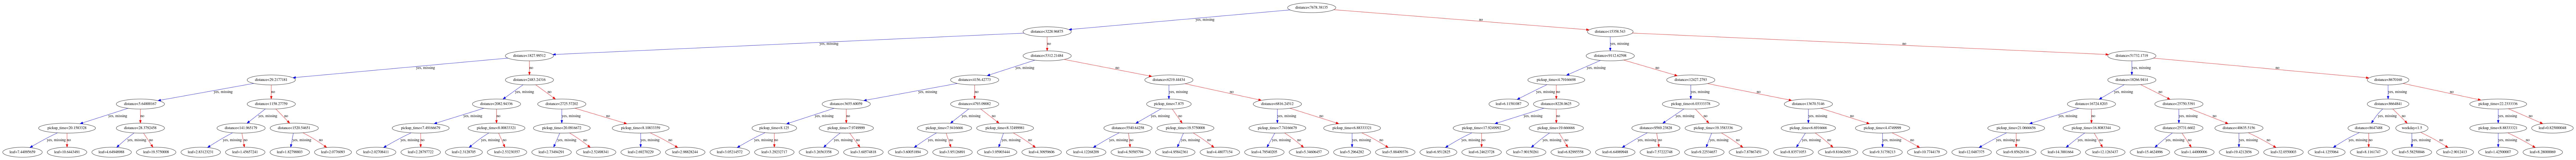

In [288]:
xgb.plot_tree(grid_xg.best_estimator_,num_trees=0)
plt.show()

# Predict the taxi fare for Test Data

In [296]:
test = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/test.csv", parse_dates=['pickup_datetime'])

testData = featureCleanup(test, False)


In [297]:
testData.head()

,passenger_count,weekday,pickup_hour,pickup_time,distance
0,1,Tuesday,13,13.133333,2323.988984
1,1,Tuesday,13,13.133333,2426.114358
2,1,Saturday,11,11.883333,618.822072
3,1,Saturday,21,21.200000,1961.648128
4,1,Saturday,21,21.200000,5388.992449


In [298]:
testData.drop(columns=['pickup_hour'], inplace=True)
testData['weekday'] = testData['weekday'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7})

In [299]:
y_test_pred_xg_cv = grid_xg.predict(testData)
y_test_pred_xg_cv

array([ 9.45629  ,  9.781892 ,  4.6610837, ..., 53.02074  , 24.63283  ,
        6.76591  ], dtype=float32)

In [300]:
test['fare_amount_predicted'] = y_test_pred_xg_cv
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_predicted
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,9.456290
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,9.781892
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,4.661084
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,7.860748
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,15.190593
